In [1]:
#Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.stats.proportion import proportion_confint
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
import joblib
import os

# Data Cleaning

In [2]:
#Survey
breast_cancer_survey= pd.read_csv ('Data Analysis.csv')
breast_cancer_survey

,Carimbo de data/hora,História clínica de cancro da mama,"Se respondeu sim na pergunta anterior, selecione a lateralidade",Idade,Sexo,Hábitos tabágicos,Hábitos alcoólicos,Peso(Kg),Altura (cm),Amamentação,Contracepção oral
0,2024/01/09 18:07:53,NaN,NaN,47,Masculino,Não,Sim,85,182,Não,Não
1,2024/01/09 18:07:55,NaN,NaN,43,Masculino,Não,Sim,83.5,170,Não,Não
2,2024/01/09 18:08:07,NaN,NaN,71,Masculino,Não,Sim,96,176,Não,Não
3,2024/01/09 18:09:19,NaN,NaN,25,Feminino,Não,Sim,60,167,Não,Sim
4,2024/01/09 18:09:59,NaN,NaN,75,Feminino,Não,Sim,54,1.61,Não,Não
...,...,...,...,...,...,...,...,...,...,...,...
102,2024/01/14 13:16:23,Não,NaN,40,Feminino,Não,Sim,76,167,Sim,Não
103,2024/01/14 13:32:02,Não,NaN,40,Masculino,Sim,Sim,78,180,Não,Não
104,2024/01/14 13:50:35,Não,NaN,28,Feminino,Não,Não,70,166,Não,Sim
105,2024/01/14 15:30:52,Não,NaN,25,Feminino,Sim,Não,70,156,Não,Não


In [3]:
breast_cancer_survey.drop('Carimbo de data/hora', axis=1, inplace=True)

In [4]:
# Translate values in the 'Sim'/'Não' columns to 'Yes'/'No'
breast_cancer_survey.replace({'Sim': 'Yes', 'Não': 'No', 'Masculino': 'Male', 'Feminino': 'Female','Bilateral': 'Both', 'Direita': 'Right','Esquerda': 'Left' }, inplace=True)

# Remove extra spaces at the end of column names
breast_cancer_survey.columns = breast_cancer_survey.columns.str.strip()

# Translate column names to English
english_column = {
    'História clínica de cancro da mama': 'Breast_cancer_history',
    'Se respondeu sim na pergunta anterior, selecione a lateralidade': 'Select_laterality_if_breast_cancer',
    'Idade': 'Age',
    'Sexo': 'Gender',
    'Hábitos tabágicos': 'Smoking_habits',
    'Hábitos alcoólicos': 'Alcohol_habits',
    'Peso(Kg)': 'Weight(Kg)',
    'Altura (cm)': 'Height(m)',
    'Amamentação': 'Breastfeeding',
    'Contracepção oral': 'Oral_contraception'
}

breast_cancer_survey.rename(columns=english_column, inplace=True)


In [5]:
# Fill NaN values in the 'Breast_cancer_history' column with 'No'
breast_cancer_survey['Breast_cancer_history'].fillna('No', inplace=True)

# Convert 'Age' column to numeric
breast_cancer_survey['Age'] = pd.to_numeric(breast_cancer_survey['Age'], errors='coerce')


# Replace commas with dots in 'Weight(Kg)' column
breast_cancer_survey['Weight(Kg)'] = breast_cancer_survey['Weight(Kg)'].replace(',', '.', regex=True).astype(float)


# Replace commas with dots in 'Height(m)' column
breast_cancer_survey['Height(m)'] = breast_cancer_survey['Height(m)'].replace(',', '.', regex=True).astype(float)

# Convert values in centimeters to meters
breast_cancer_survey['Height(m)'] = breast_cancer_survey['Height(m)'].apply(lambda x: x / 100 if pd.notna(x) and x >= 100 else x)

breast_cancer_survey

,Breast_cancer_history,Select_laterality_if_breast_cancer,Age,Gender,Smoking_habits,Alcohol_habits,Weight(Kg),Height(m),Breastfeeding,Oral_contraception
0,No,NaN,47,Male,No,Yes,85.0,1.82,No,No
1,No,NaN,43,Male,No,Yes,83.5,1.70,No,No
2,No,NaN,71,Male,No,Yes,96.0,1.76,No,No
3,No,NaN,25,Female,No,Yes,60.0,1.67,No,Yes
4,No,NaN,75,Female,No,Yes,54.0,1.61,No,No
...,...,...,...,...,...,...,...,...,...,...
102,No,NaN,40,Female,No,Yes,76.0,1.67,Yes,No
103,No,NaN,40,Male,Yes,Yes,78.0,1.80,No,No
104,No,NaN,28,Female,No,No,70.0,1.66,No,Yes
105,No,NaN,25,Female,Yes,No,70.0,1.56,No,No


In [6]:
missing_values = breast_cancer_survey.isnull().sum()
print(missing_values)

Breast_cancer_history                   0
Select_laterality_if_breast_cancer    102
Age                                     0
Gender                                  0
Smoking_habits                          0
Alcohol_habits                          0
Weight(Kg)                              0
Height(m)                               0
Breastfeeding                           0
Oral_contraception                      0
dtype: int64


In [7]:
#People with cancer
breast_cancer = pd.read_excel('Survey.xlsx')
breast_cancer

,ID,Age,Gender,Alcohol,Smoke,Breast side,Weight (Kg),Height (cm),Oral Contraception,Breastfeeding
0,NaN,60,F,No,No,Left,82.0,166,No,Yes
1,NaN,62,F,No,No,Left,92.0,165,Yes,No
2,NaN,57,F,No,No,Left,58.0,169,No,No
3,NaN,61,F,No,No,Both,53.0,150,Yes,Yes
4,NaN,64,F,Yes,No,Left,64.0,157,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...
97,NaN,81,F,Yes,No,Right,81.0,160,Yes,Yes
98,NaN,67,F,Yes,Yes,Right,71.0,159,Yes,Yes
99,NaN,69,F,No,No,Right,82.0,161,No,No
100,NaN,54,F,Yes,Yes,Right,53.0,153,Yes,Yes


In [8]:
breast_cancer.drop('ID', axis=1, inplace=True)

In [9]:
# Remove extra spaces at the end of column names
breast_cancer.columns = breast_cancer.columns.str.strip()

# Change column names
english_column = {
    'História clínica de cancro da mama': 'Breast_cancer_history',
    'Breast side': 'Select_laterality_if_breast_cancer',
    'Smoke': 'Smoking_habits',
    'Alcohol': 'Alcohol_habits',
    'Height(cm)': 'Height(m)',
    'Oral Contraception': 'Oral_contraception'
}

breast_cancer.rename(columns=english_column, inplace=True)

# Create a column 'Breast_cancer_history' filled with 'Yes'
breast_cancer['Breast_cancer_history'] = 'Yes'
breast_cancer.replace({'M': 'Male', 'F': 'Female'}, inplace=True)



In [10]:
# If the column names have leading/trailing whitespaces, remove them
breast_cancer.columns = breast_cancer.columns.str.strip()

# Convert 'Age' column to numeric
breast_cancer['Age'] = pd.to_numeric(breast_cancer['Age'], errors='coerce')

# Replace commas with dots in 'Weight (Kg)' column
breast_cancer['Weight(Kg)'] = breast_cancer['Weight (Kg)'].replace(',', '.', regex=True).astype(float)

# Replace commas with dots in 'Height(m)' column
breast_cancer['Height(m)'] = breast_cancer['Height (cm)'].replace(',', '.', regex=True).astype(float)

# Convert values in centimeters to meters
breast_cancer['Height(m)'] = breast_cancer['Height(m)'].apply(lambda x: x / 100 if pd.notna(x) and x >= 100 else x)

# Remove the specified columns
breast_cancer = breast_cancer.drop(['Weight (Kg)', 'Height (cm)'], axis=1)


In [11]:
missing_values = breast_cancer.isnull().sum()
print(missing_values)

Age                                   0
Gender                                0
Alcohol_habits                        0
Smoking_habits                        0
Select_laterality_if_breast_cancer    0
Oral_contraception                    0
Breastfeeding                         0
Breast_cancer_history                 0
Weight(Kg)                            0
Height(m)                             0
dtype: int64


In [12]:
breast_cancer

,Age,Gender,Alcohol_habits,Smoking_habits,Select_laterality_if_breast_cancer,Oral_contraception,Breastfeeding,Breast_cancer_history,Weight(Kg),Height(m)
0,60,Female,No,No,Left,No,Yes,Yes,82.0,1.66
1,62,Female,No,No,Left,Yes,No,Yes,92.0,1.65
2,57,Female,No,No,Left,No,No,Yes,58.0,1.69
3,61,Female,No,No,Both,Yes,Yes,Yes,53.0,1.50
4,64,Female,Yes,No,Left,Yes,Yes,Yes,64.0,1.57
...,...,...,...,...,...,...,...,...,...,...
97,81,Female,Yes,No,Right,Yes,Yes,Yes,81.0,1.60
98,67,Female,Yes,Yes,Right,Yes,Yes,Yes,71.0,1.59
99,69,Female,No,No,Right,No,No,Yes,82.0,1.61
100,54,Female,Yes,Yes,Right,Yes,Yes,Yes,53.0,1.53


In [13]:
# Concatenate the two data frames vertically
breast_cancer_df= pd.concat([breast_cancer_survey, breast_cancer], ignore_index=True)

# Clean leading and trailing spaces in the 'Oral_contraception' column
breast_cancer_df['Oral_contraception'] = breast_cancer_df['Oral_contraception'].str.strip()

# Replace 'No ' with 'No'
breast_cancer_df['Oral_contraception'] = breast_cancer_df['Oral_contraception'].replace('No ', 'No')

# Verify the cleaned DataFrame
print(breast_cancer_df['Oral_contraception'].unique())


['No' 'Yes']


In [14]:
missing_values = breast_cancer_df.isnull().sum()
print(missing_values)

Breast_cancer_history                   0
Select_laterality_if_breast_cancer    102
Age                                     0
Gender                                  0
Smoking_habits                          0
Alcohol_habits                          0
Weight(Kg)                              0
Height(m)                               0
Breastfeeding                           0
Oral_contraception                      0
dtype: int64


# Data Manipulation

In [15]:
breast_cancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 10 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Breast_cancer_history               209 non-null    object 
 1   Select_laterality_if_breast_cancer  107 non-null    object 
 2   Age                                 209 non-null    int64  
 3   Gender                              209 non-null    object 
 4   Smoking_habits                      209 non-null    object 
 5   Alcohol_habits                      209 non-null    object 
 6   Weight(Kg)                          209 non-null    float64
 7   Height(m)                           209 non-null    float64
 8   Breastfeeding                       209 non-null    object 
 9   Oral_contraception                  209 non-null    object 
dtypes: float64(2), int64(1), object(7)
memory usage: 16.5+ KB


In [16]:
# 'BMI' calculation
breast_cancer_df['BMI'] = (breast_cancer_df['Weight(Kg)'] / (breast_cancer_df['Height(m)'] ** 2)).round(1)
# Create 'Weight_Status' column based on BMI categories
breast_cancer_df['Weight_status'] = pd.cut(breast_cancer_df['BMI'],
                                               bins=[-float('inf'), 18.5, 25, 30, 35, 40, float('inf')],
                                               labels=['Underweight', 'Normal weight', 'Overweight', 'Obesity class I', 'Obesity class II', 'Obesity class III'])


breast_cancer_df

,Breast_cancer_history,Select_laterality_if_breast_cancer,Age,Gender,Smoking_habits,Alcohol_habits,Weight(Kg),Height(m),Breastfeeding,Oral_contraception,BMI,Weight_status
0,No,NaN,47,Male,No,Yes,85.0,1.82,No,No,25.7,Overweight
1,No,NaN,43,Male,No,Yes,83.5,1.70,No,No,28.9,Overweight
2,No,NaN,71,Male,No,Yes,96.0,1.76,No,No,31.0,Obesity class I
3,No,NaN,25,Female,No,Yes,60.0,1.67,No,Yes,21.5,Normal weight
4,No,NaN,75,Female,No,Yes,54.0,1.61,No,No,20.8,Normal weight
...,...,...,...,...,...,...,...,...,...,...,...,...
204,Yes,Right,81,Female,No,Yes,81.0,1.60,Yes,Yes,31.6,Obesity class I
205,Yes,Right,67,Female,Yes,Yes,71.0,1.59,Yes,Yes,28.1,Overweight
206,Yes,Right,69,Female,No,No,82.0,1.61,No,No,31.6,Obesity class I
207,Yes,Right,54,Female,Yes,Yes,53.0,1.53,Yes,Yes,22.6,Normal weight


In [17]:
# Specify the file path where you want to save the CSV file
csv_file_path = '/Users/miguelmendes/Desktop/Ironhack/Mid Camp Project/breast_cancer_df.csv'

# Use the to_csv method to export the DataFrame to a CSV file without the index column
breast_cancer_df.to_csv(csv_file_path, index=False)


# Data Analysis

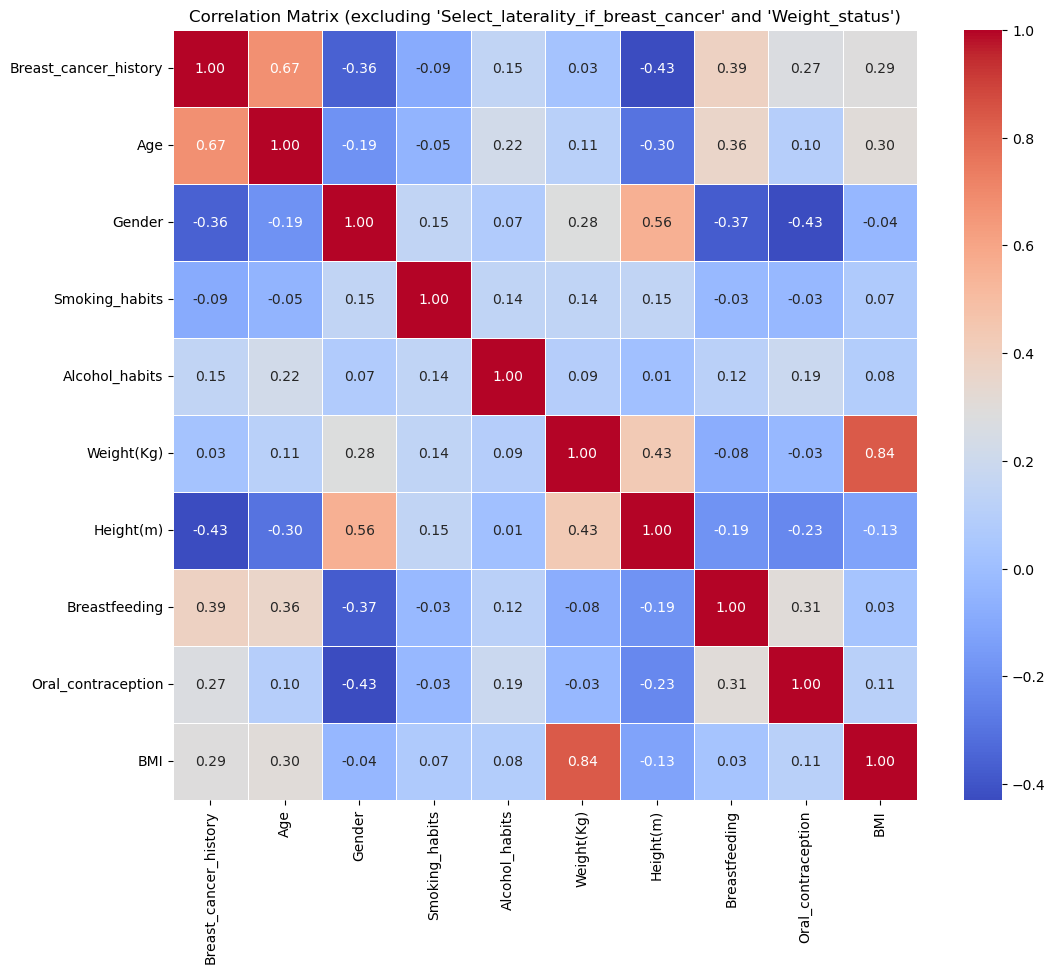

In [18]:
breast_cancer_correlation= breast_cancer_df.copy()

# Drop 'Select_laterality_if_breast_cancer' and 'Weight_status' columns
columns_to_exclude = ['Select_laterality_if_breast_cancer', 'Weight_status']
filtered_df = breast_cancer_correlation.drop(columns=columns_to_exclude, errors='ignore')


# Encode categorical variables with LabelEncoder
label_encoder = LabelEncoder()
for col in filtered_df.select_dtypes(include=['object']).columns:
    filtered_df[col] = label_encoder.fit_transform(filtered_df[col])

# Calculate the correlation matrix
corr_matrix = filtered_df.corr()

# Plotting the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix (excluding 'Select_laterality_if_breast_cancer' and 'Weight_status')")
plt.show()


In [19]:
#full data
analysis_breast_cancer= breast_cancer_df.copy()
analysis_breast_cancer

,Breast_cancer_history,Select_laterality_if_breast_cancer,Age,Gender,Smoking_habits,Alcohol_habits,Weight(Kg),Height(m),Breastfeeding,Oral_contraception,BMI,Weight_status
0,No,NaN,47,Male,No,Yes,85.0,1.82,No,No,25.7,Overweight
1,No,NaN,43,Male,No,Yes,83.5,1.70,No,No,28.9,Overweight
2,No,NaN,71,Male,No,Yes,96.0,1.76,No,No,31.0,Obesity class I
3,No,NaN,25,Female,No,Yes,60.0,1.67,No,Yes,21.5,Normal weight
4,No,NaN,75,Female,No,Yes,54.0,1.61,No,No,20.8,Normal weight
...,...,...,...,...,...,...,...,...,...,...,...,...
204,Yes,Right,81,Female,No,Yes,81.0,1.60,Yes,Yes,31.6,Obesity class I
205,Yes,Right,67,Female,Yes,Yes,71.0,1.59,Yes,Yes,28.1,Overweight
206,Yes,Right,69,Female,No,No,82.0,1.61,No,No,31.6,Obesity class I
207,Yes,Right,54,Female,Yes,Yes,53.0,1.53,Yes,Yes,22.6,Normal weight


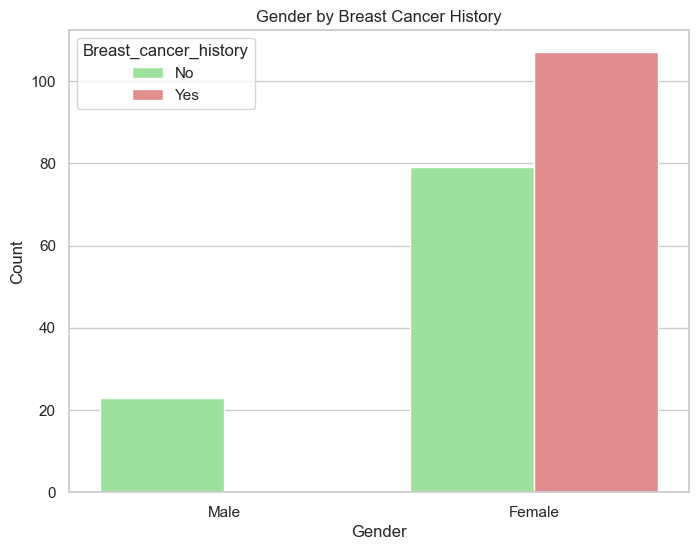

In [20]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Define custom light colors
custom_palette = {"Yes": "lightcoral", "No": "lightgreen"}


# Create a count plot with custom colors
plt.figure(figsize=(8, 6))
sns.countplot(x="Gender", hue="Breast_cancer_history", data=analysis_breast_cancer, palette=custom_palette)

# Set labels and title
plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Gender by Breast Cancer History")
# Save the plot as a PNG file
plt.savefig("Gender by Breast Cancer History")

# Show the plot
plt.show()

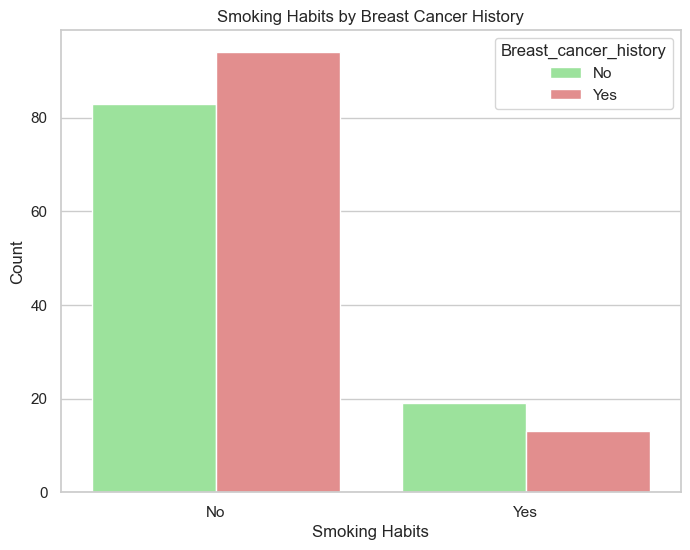

In [21]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Define custom light colors
custom_palette = {"Yes": "lightcoral", "No": "lightgreen"}


# Create a count plot with custom colors
plt.figure(figsize=(8, 6))
sns.countplot(x="Smoking_habits", hue="Breast_cancer_history", data=analysis_breast_cancer, palette=custom_palette)

# Set labels and title
plt.xlabel("Smoking Habits")
plt.ylabel("Count")
plt.title("Smoking Habits by Breast Cancer History")
# Save the plot as a PNG file
plt.savefig("Smoking Habits by Breast Cancer History")

# Show the plot
plt.show()

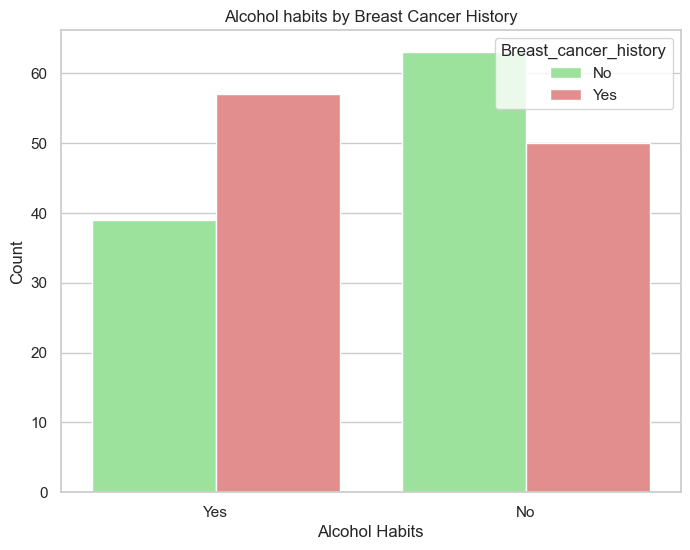

In [22]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Define custom light colors
custom_palette = {"Yes": "lightcoral", "No": "lightgreen"}


# Create a count plot with custom colors
plt.figure(figsize=(8, 6))
sns.countplot(x="Alcohol_habits", hue="Breast_cancer_history", data=analysis_breast_cancer, palette=custom_palette)

# Set labels and title
plt.xlabel("Alcohol Habits")
plt.ylabel("Count")
plt.title("Alcohol habits by Breast Cancer History")
# Save the plot as a PNG file
plt.savefig("Alcohol Habits by Breast Cancer History")

# Show the plot
plt.show()


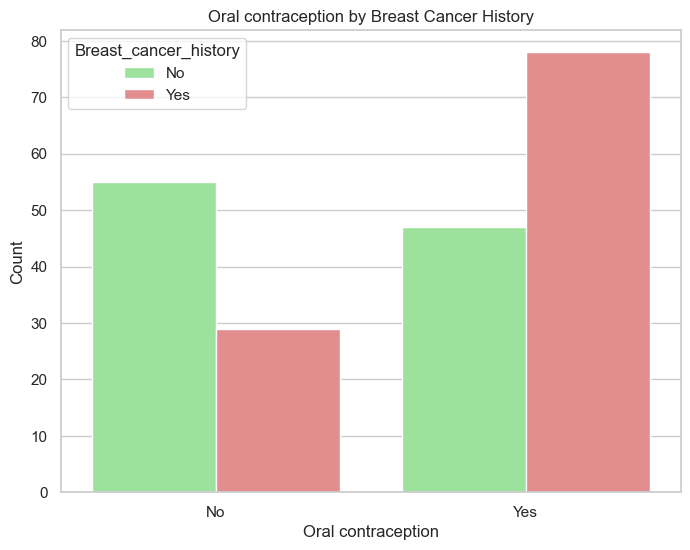

In [23]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Define custom light colors
custom_palette = {"Yes": "lightcoral", "No": "lightgreen"}


# Create a count plot with custom colors
plt.figure(figsize=(8, 6))
sns.countplot(x="Oral_contraception", hue="Breast_cancer_history", data=analysis_breast_cancer, palette=custom_palette)

# Set labels and title
plt.xlabel("Oral contraception")
plt.ylabel("Count")
plt.title("Oral contraception by Breast Cancer History")
# Save the plot as a PNG file
plt.savefig("Oral contraception by Breast Cancer History")

# Show the plot
plt.show()


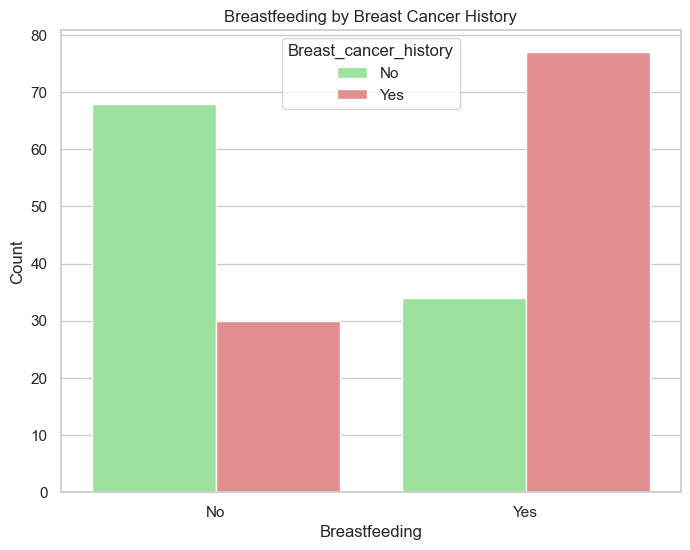

In [24]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Define custom light colors
custom_palette = {"Yes": "lightcoral", "No": "lightgreen"}


# Create a count plot with custom colors
plt.figure(figsize=(8, 6))
sns.countplot(x="Breastfeeding", hue="Breast_cancer_history", data=analysis_breast_cancer, palette=custom_palette)

# Set labels and title
plt.xlabel("Breastfeeding")
plt.ylabel("Count")
plt.title("Breastfeeding by Breast Cancer History")
# Save the plot as a PNG file
plt.savefig("Breastfeeding by Breast Cancer History")

# Show the plot
plt.show()


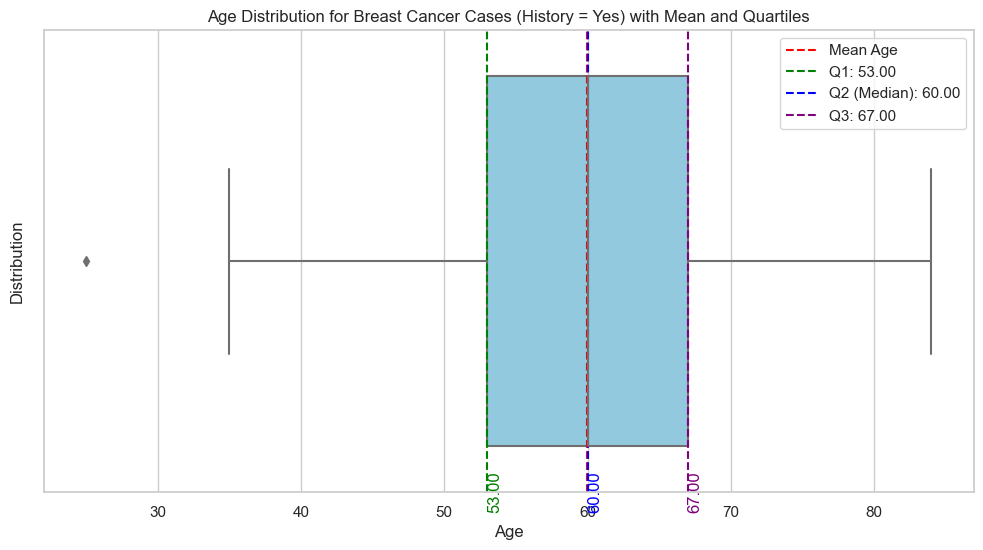

In [25]:
# Assuming you have a DataFrame named df
# Create a subset of the data where Breast Cancer History is Yes
df_yes = analysis_breast_cancer[analysis_breast_cancer['Breast_cancer_history'] == 'Yes']

# Set the style of seaborn for better visualization
sns.set(style="whitegrid")

# Create a boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Age', data=df_yes, color='skyblue')
plt.title('Age Distribution for Breast Cancer Cases (History = Yes) with Mean and Quartiles')
plt.xlabel('Age')
plt.ylabel('Distribution')

# Add a reference line (e.g., mean age)
mean_age = df_yes['Age'].mean()
plt.axvline(x=mean_age, color='red', linestyle='--', label='Mean Age')

# Add quartiles
q1 = df_yes['Age'].quantile(0.25)
q2 = df_yes['Age'].quantile(0.50)
q3 = df_yes['Age'].quantile(0.75)

plt.axvline(x=q1, color='green', linestyle='--', label=f'Q1: {q1:.2f}')
plt.axvline(x=q2, color='blue', linestyle='--', label=f'Q2 (Median): {q2:.2f}')
plt.axvline(x=q3, color='purple', linestyle='--', label=f'Q3: {q3:.2f}')


# Show the plot with legend
plt.legend()

# Display numerical values as annotations
plt.text(q1, 0.5, f'{q1:.2f}', rotation=90, verticalalignment='center', color='green')
plt.text(q2, 0.5, f'{q2:.2f}', rotation=90, verticalalignment='center', color='blue')
plt.text(q3, 0.5, f'{q3:.2f}', rotation=90, verticalalignment='center', color='purple')

# Save the plot as a PNG file
plt.savefig("boxplot-Age Distribution for Breast Cancer Cases (History = Yes) with Mean and Quartiles.png")

# Show the plot
plt.show()


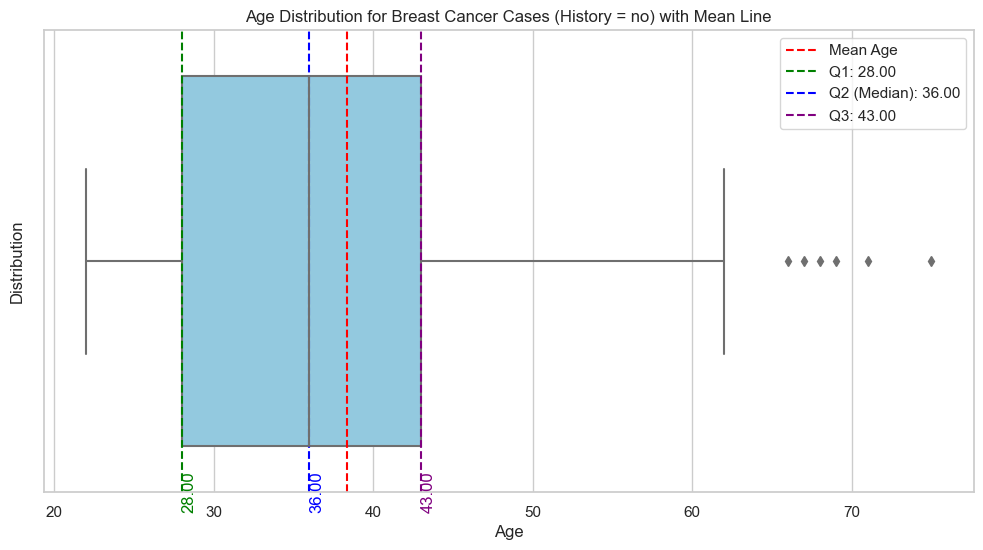

In [26]:
# Assuming you have a DataFrame named df
# Create a subset of the data where Breast Cancer History is Yes
df_no = analysis_breast_cancer[analysis_breast_cancer['Breast_cancer_history'] == 'No']

# Set the style of seaborn for better visualization
sns.set(style="whitegrid")

# Create a boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Age', data=df_no, color='skyblue')
plt.title('Age Distribution for Breast Cancer Cases (History = no) with Mean Line')
plt.xlabel('Age')
plt.ylabel('Distribution')

# Add a reference line (e.g., median age)
median_age = df_no['Age'].mean()
plt.axvline(x=median_age, color='red', linestyle='--', label='Mean Age')

# Add quartiles
q1 = df_no['Age'].quantile(0.25)
q2 = df_no['Age'].quantile(0.50)
q3 = df_no['Age'].quantile(0.75)

plt.axvline(x=q1, color='green', linestyle='--', label=f'Q1: {q1:.2f}')
plt.axvline(x=q2, color='blue', linestyle='--', label=f'Q2 (Median): {q2:.2f}')
plt.axvline(x=q3, color='purple', linestyle='--', label=f'Q3: {q3:.2f}')


# Show the plot with legend
plt.legend()

# Display numerical values as annotations
plt.text(q1, 0.5, f'{q1:.2f}', rotation=90, verticalalignment='center', color='green')
plt.text(q2, 0.5, f'{q2:.2f}', rotation=90, verticalalignment='center', color='blue')
plt.text(q3, 0.5, f'{q3:.2f}', rotation=90, verticalalignment='center', color='purple')


# Save the plot as a PNG file
plt.savefig("boxplot-Age Distribution for Breast Cancer Cases (History = no) with Mean Line'")

# Show the plot
plt.show()


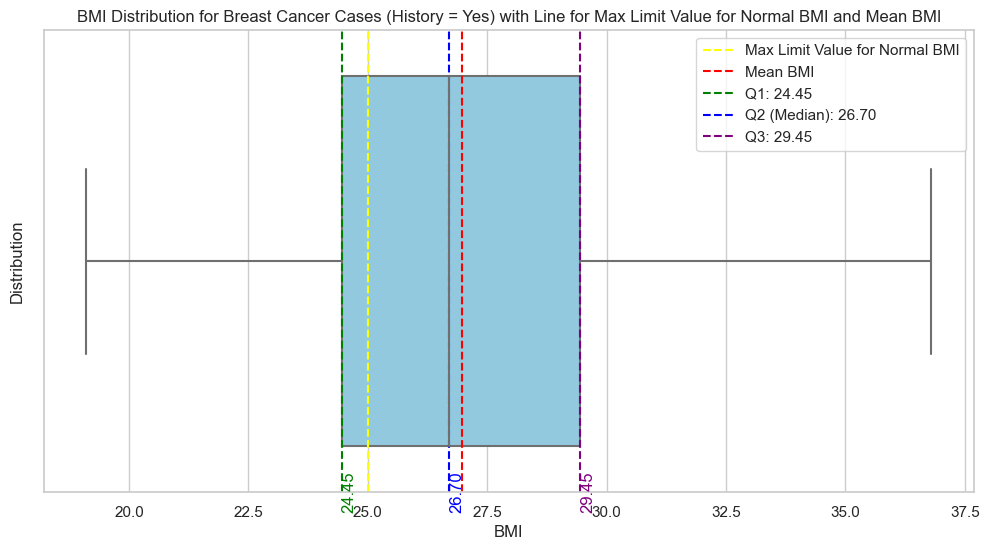

In [27]:
# Assuming you have a DataFrame named analysis_breast_cancer
# Create a subset of the data where Breast Cancer History is Yes
df_yes = analysis_breast_cancer[analysis_breast_cancer['Breast_cancer_history'] == 'Yes']

# Set the style of seaborn for better visualization
sns.set(style="whitegrid")

# Create a boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='BMI', data=df_yes, color='skyblue')

# Add a reference line for the maximum normal BMI
max_normal_limit = 25
plt.axvline(x=max_normal_limit, color='yellow', linestyle='--', label='Max Limit Value for Normal BMI')

# Add a reference line for the mean BMI
mean_BMI = df_yes['BMI'].mean()
plt.axvline(x=mean_BMI, color='red', linestyle='--', label='Mean BMI')

# Set plot title, x-axis label, y-axis label, and legend
plt.title('BMI Distribution for Breast Cancer Cases (History = Yes) with Line for Max Limit Value for Normal BMI and Mean BMI')
plt.xlabel('BMI')
plt.ylabel('Distribution')
plt.legend(loc='upper right')


# Add quartiles
q1 = df_yes['BMI'].quantile(0.25)
q2 = df_yes['BMI'].quantile(0.50)
q3 = df_yes['BMI'].quantile(0.75)

plt.axvline(x=q1, color='green', linestyle='--', label=f'Q1: {q1:.2f}')
plt.axvline(x=q2, color='blue', linestyle='--', label=f'Q2 (Median): {q2:.2f}')
plt.axvline(x=q3, color='purple', linestyle='--', label=f'Q3: {q3:.2f}')


# Show the plot with legend
plt.legend()

# Display numerical values as annotations
plt.text(q1, 0.5, f'{q1:.2f}', rotation=90, verticalalignment='center', color='green')
plt.text(q2, 0.5, f'{q2:.2f}', rotation=90, verticalalignment='center', color='blue')
plt.text(q3, 0.5, f'{q3:.2f}', rotation=90, verticalalignment='center', color='purple')


# Save the plot as a PNG file
plt.savefig('BMI Distribution for Breast Cancer Cases (History = Yes) with Line for Max Limit Value for Normal BMI and Mean BMI')

# Show the plot
plt.show()



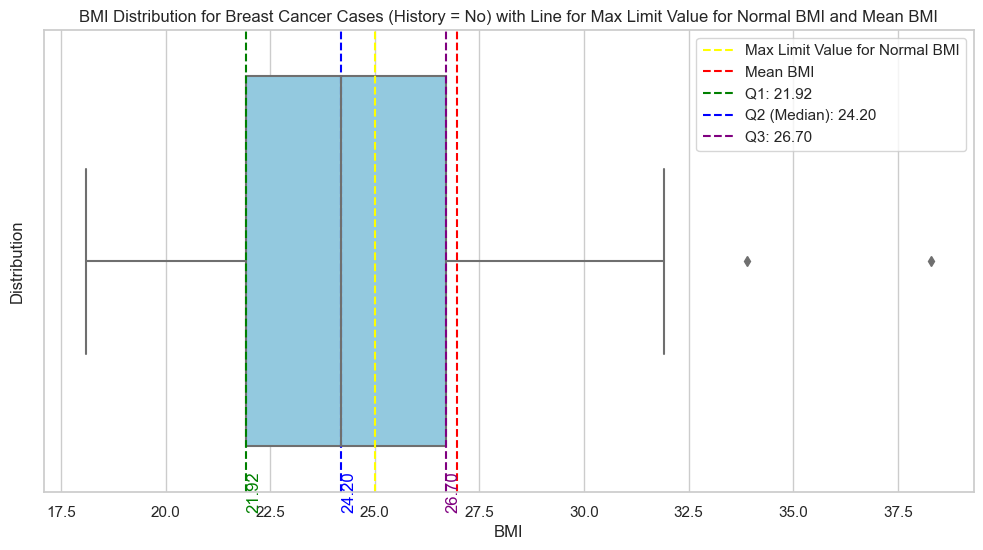

In [28]:
# Assuming you have a DataFrame named analysis_breast_cancer
# Create a subset of the data where Breast Cancer History is Yes
df_no = analysis_breast_cancer[analysis_breast_cancer['Breast_cancer_history'] == 'No']

# Set the style of seaborn for better visualization
sns.set(style="whitegrid")

# Create a boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='BMI', data=df_no, color='skyblue')

# Add a reference line for the maximum normal BMI
max_normal_limit = 25
plt.axvline(x=max_normal_limit, color='yellow', linestyle='--', label='Max Limit Value for Normal BMI')

# Add a reference line for the mean BMI
mean_BMI = df_yes['BMI'].mean()
plt.axvline(x=mean_BMI, color='red', linestyle='--', label='Mean BMI')

# Set plot title, x-axis label, y-axis label, and legend
plt.title('BMI Distribution for Breast Cancer Cases (History = No) with Line for Max Limit Value for Normal BMI and Mean BMI')
plt.xlabel('BMI')
plt.ylabel('Distribution')
plt.legend(loc='upper right')

# Add quartiles
q1 = df_no['BMI'].quantile(0.25)
q2 = df_no['BMI'].quantile(0.50)
q3 = df_no['BMI'].quantile(0.75)

plt.axvline(x=q1, color='green', linestyle='--', label=f'Q1: {q1:.2f}')
plt.axvline(x=q2, color='blue', linestyle='--', label=f'Q2 (Median): {q2:.2f}')
plt.axvline(x=q3, color='purple', linestyle='--', label=f'Q3: {q3:.2f}')


# Show the plot with legend
plt.legend()

# Display numerical values as annotations
plt.text(q1, 0.5, f'{q1:.2f}', rotation=90, verticalalignment='center', color='green')
plt.text(q2, 0.5, f'{q2:.2f}', rotation=90, verticalalignment='center', color='blue')
plt.text(q3, 0.5, f'{q3:.2f}', rotation=90, verticalalignment='center', color='purple')




# Save the plot as a PNG file
plt.savefig("boxplot-'BMI Distribution for Breast Cancer Cases (History = No) with Line for Max Limit Value for Normal BMI and Mean BMI'")


# Show the plot
plt.show()



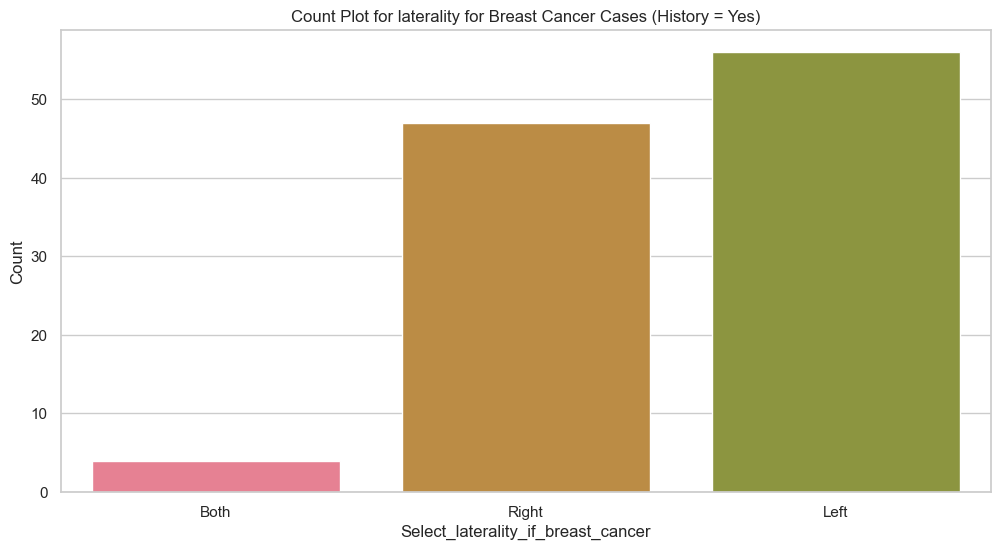

In [29]:
# Assuming you have a DataFrame named breast_ca_survey
# Create a subset of the data where Breast Cancer History is Yes
df_yes = analysis_breast_cancer[analysis_breast_cancer['Breast_cancer_history'] == 'Yes']

# Set a custom color palette
custom_palette = sns.color_palette("husl", 8)

# Set the style of seaborn for better visualization
sns.set(style="whitegrid")

# Create a count plot for Select_laterality_if_breast_cancer with the custom color palette
plt.figure(figsize=(12, 6))
sns.countplot(x='Select_laterality_if_breast_cancer', data=df_yes, palette=custom_palette)
plt.title('Count Plot for laterality for Breast Cancer Cases (History = Yes)')
plt.xlabel('Select_laterality_if_breast_cancer')
plt.ylabel('Count')

# Save the plot as a PNG file
plt.savefig('Count Plot for laterality for Breast Cancer Cases (History = Yes)')

# Show the plot
plt.show()



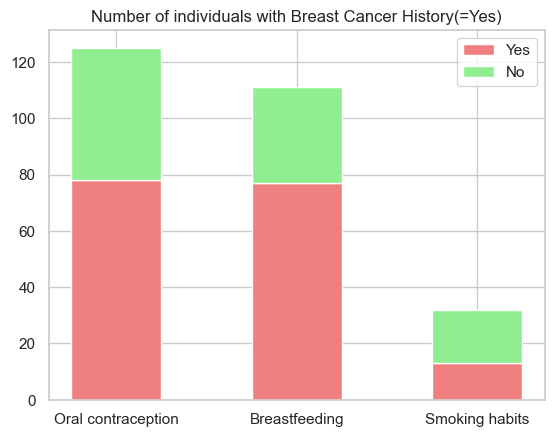

In [63]:
# Assuming analysis_breast_cancer is a DataFrame containing the required columns
count_yes = ((analysis_breast_cancer['Breast_cancer_history'] == 'Yes') & (analysis_breast_cancer['Oral_contraception'] == 'Yes')).sum()
count_no = ((analysis_breast_cancer['Breast_cancer_history'] == 'No') & (analysis_breast_cancer['Oral_contraception'] == 'Yes')).sum()
count_yes_breastfeeding = ((analysis_breast_cancer['Breast_cancer_history'] == 'Yes') & (analysis_breast_cancer['Breastfeeding'] == 'Yes')).sum()
count_no_breastfeeding = ((analysis_breast_cancer['Breast_cancer_history'] == 'No') & (analysis_breast_cancer['Breastfeeding'] == 'Yes')).sum()
count_yes_smoking = ((analysis_breast_cancer['Breast_cancer_history'] == 'Yes') & (analysis_breast_cancer['Smoking_habits'] == 'Yes')).sum()
count_no_smoking = ((analysis_breast_cancer['Breast_cancer_history'] == 'No') & (analysis_breast_cancer['Smoking_habits'] == 'Yes')).sum()

species = (
    "Oral contraception",
    "Breastfeeding",
    "Smoking habits",
)

custom_palette = {"Yes": "lightcoral", "No": "lightgreen"}

# Create a dictionary with corrected structure
weight_counts = {
    "Yes": [count_yes, count_yes_breastfeeding, count_yes_smoking],
    "No": [count_no, count_no_breastfeeding, count_no_smoking]
}

width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(3)

for boolean, weight_count in weight_counts.items():
    p = ax.bar(species, weight_count, width, label=boolean, bottom=bottom, color=custom_palette[boolean])
    bottom += weight_count

ax.set_title("Number of individuals with Breast Cancer History(=Yes)")
ax.legend(loc="upper right")

# Save the plot as a PNG file
plt.savefig("Number of individuals with Breast Cancer History(=Yes)")

plt.show()



# Statistical Analysis

# Is Smoking a risk factor for breast cancer?

In [30]:
breast_cancer_df_copy = breast_cancer_df.copy()

# Create a label encoder
label_encoder = LabelEncoder()

# Encode 'Smoking_habits' column
breast_cancer_df_copy['Smoking_habits'] = label_encoder.fit_transform(breast_cancer_df_copy['Smoking_habits'])


# Split the data into two groups based on 'Breast_cancer_history'
breast_cancer_group = breast_cancer_df_copy[breast_cancer_df_copy['Breast_cancer_history'] == 'Yes']
no_breast_cancer_group = breast_cancer_df_copy[breast_cancer_df_copy['Breast_cancer_history'] == 'No']

# Perform t-test for Smoking habits
t_statistic, p_value = ttest_ind(breast_cancer_group['Smoking_habits'], no_breast_cancer_group['Smoking_habits'], equal_var=False)

# Display the results
print(f'T-statistic: {t_statistic:.4f}')
print(f'P-value: {p_value:.4f}')

# Check the significance level
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in Smoking habits between individuals with and without a history of breast cancer.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in Smoking habits between individuals with and without a history of breast cancer.")


T-statistic: -1.2936
P-value: 0.1973
Fail to reject the null hypothesis: There is no significant difference in Smoking habits between individuals with and without a history of breast cancer.


T-statistic: -1.2936
P-value: 0.1973


The t-statistic is calculated as the difference between the means of two groups (with and without a history of breast cancer) divided by the standard error of the difference. In this case:

T-statistic: -1.2936
The negative sign indicates that the mean of the group with a history of breast cancer is lower than the mean of the group without a history of breast cancer. However, the magnitude of the t-statistic is relatively small, indicating that the difference between the two groups is not large in relation to the variability within each group.

The t-statistic is then compared to a critical value or used to calculate a p-value. The p-value represents the probability of observing a t-statistic as extreme as the one computed, assuming the null hypothesis is true. Here:

P-value: 0.1973
The p-value of 0.1973 is greater than the common significance level of 0.05. This means that there is a 19.73% probability of observing a t-statistic as extreme as the one calculated, purely by chance, if there is no true difference in smoking habits between the two groups.

Since the p-value is greater than 0.05, fail to reject the null hypothesis. In practical terms, this suggests that the observed difference in smoking habits between individuals with and without a history of breast cancer is not statistically significant. The results do not provide enough evidence to conclude that the difference is not due to random variability.

In summary, the t-statistic and p-value together indicate that the observed difference in smoking habits between the two groups is likely due to chance, and you do not have enough evidence to support a significant association between smoking habits and a history of breast cancer in your sample.













In [31]:
# Encode categorical variables with LabelEncoder
label_encoder = LabelEncoder()
categorical_columns = ['Breast_cancer_history', 'Smoking_habits']
for col in categorical_columns:
    breast_cancer_df_copy[col] = label_encoder.fit_transform(breast_cancer_df_copy[col])

# Add an intercept term for logistic regression
breast_cancer_df_copy['intercept'] = 1

# Define independent variables (X) and the dependent variable (y)
X = breast_cancer_df_copy[['intercept', 'Smoking_habits']]
y = breast_cancer_df_copy['Breast_cancer_history']

# Fit logistic regression model
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# Display the logistic regression summary
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.688803
         Iterations 4
                             Logit Regression Results                            
Dep. Variable:     Breast_cancer_history   No. Observations:                  209
Model:                             Logit   Df Residuals:                      207
Method:                              MLE   Df Model:                            1
Date:                   Sat, 27 Jan 2024   Pseudo R-squ.:                0.005856
Time:                           06:24:01   Log-Likelihood:                -143.96
converged:                          True   LL-Null:                       -144.81
Covariance Type:               nonrobust   LLR p-value:                    0.1928
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept          0.1245      0.151      0.826      0.409      -0.171      

Interpretation:
The logistic regression analysis indicates that, based on the provided data:

The intercept is statistically significant, suggesting that the odds of having a history of breast cancer are significantly different from zero when Smoking_habits is zero.
However, the coefficient for Smoking_habits is not statistically significant, indicating that there is no significant association between smoking habits and the odds of having a history of breast cancer.


# Breast Cancer and Other Features

In [32]:
breast_cancer_df_copy = breast_cancer_df.copy()

# Create a label encoder
label_encoder = LabelEncoder()

#Encode columns
breast_cancer_df_copy['Age'] = label_encoder.fit_transform(breast_cancer_df_copy['Age'])
breast_cancer_df_copy['Breastfeeding'] = label_encoder.fit_transform(breast_cancer_df_copy['Breastfeeding'])
breast_cancer_df_copy['Gender'] = label_encoder.fit_transform(breast_cancer_df_copy['Gender'])
breast_cancer_df_copy['Oral_contraception'] = label_encoder.fit_transform(breast_cancer_df_copy['Oral_contraception'])
breast_cancer_df_copy['BMI'] = label_encoder.fit_transform(breast_cancer_df_copy['BMI'])
breast_cancer_df_copy['Alcohol_habits'] = label_encoder.fit_transform(breast_cancer_df_copy['Alcohol_habits'])


# Split the data into two groups based on 'Breast_cancer_history'
breast_cancer_group = breast_cancer_df_copy[breast_cancer_df_copy['Breast_cancer_history'] == 'Yes']
no_breast_cancer_group = breast_cancer_df_copy[breast_cancer_df_copy['Breast_cancer_history'] == 'No']

#t-test

# Perform t-test for Gender
t_statistic_gender, p_value_gender = ttest_ind(breast_cancer_group['Gender'], no_breast_cancer_group['Gender'], equal_var=False)

# Perform t-test for Age
t_statistic_age, p_value_age = ttest_ind(breast_cancer_group['Age'], no_breast_cancer_group['Age'], equal_var=False)

# Perform t-test for Breastfeeding
t_statistic_breastfeeding, p_value_breastfeeding = ttest_ind(breast_cancer_group['Breastfeeding'], no_breast_cancer_group['Breastfeeding'], equal_var=False)

# Perform t-test for Oral Contraception
t_statistic_contraception, p_value_contraception = ttest_ind(breast_cancer_group['Oral_contraception'], no_breast_cancer_group['Oral_contraception'], equal_var=False)

# Perform t-test for BMI
t_statistic_BMI, p_value_BMI = ttest_ind(breast_cancer_group['BMI'], no_breast_cancer_group['BMI'], equal_var=False)

# Perform t-test for Alcohol habits
t_statistic_Alcohol_habits, p_value_Alcohol_habits = ttest_ind(breast_cancer_group['Alcohol_habits'], no_breast_cancer_group['Alcohol_habits'], equal_var=False)


#Display results

#Alcohol habits
alpha = 0.05
print(f'T-statistic (Alcohol_habits): {t_statistic_Alcohol_habits:.4f}')
print(f'P-value (Alcohol_habits): {p_value_Alcohol_habits:.4f}')
if p_value_Alcohol_habits < alpha:
    print("Reject the null hypothesis: There is a significant difference in Alcohol habits between individuals with and without a history of breast cancer.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in Alcohol habits between individuals with and without a history of breast cancer.")


# BMI
alpha = 0.05
print(f'T-statistic (BMI): {t_statistic_BMI:.4f}')
print(f'P-value (BMI): {p_value_BMI:.4f}')
if p_value_BMI < alpha:
    print("Reject the null hypothesis: There is a significant difference in BMI between individuals with and without a history of breast cancer.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in BMI between individuals with and without a history of breast cancer.")

# Oral Conctraception
alpha = 0.05
print(f'T-statistic (Oral_contraception): {t_statistic_contraception:.4f}')
print(f'P-value (Oral_contraception): {p_value_contraception:.4f}')
if p_value_contraception < alpha:
    print("Reject the null hypothesis: There is a significant difference in Oral contraception between individuals with and without a history of breast cancer.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in Oral contraception between individuals with and without a history of breast cancer.")

# Gender
alpha = 0.05
print(f'T-statistic (Gender): {t_statistic_gender:.4f}')
print(f'P-value (Gender): {p_value_gender:.4f}')
if p_value_gender < alpha:
    print("Reject the null hypothesis: There is a significant difference in Gender between individuals with and without a history of breast cancer.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in Gender between individuals with and without a history of breast cancer.")

# Age
alpha = 0.05
print(f'T-statistic (Age): {t_statistic_age:.4f}')
print(f'P-value (Age): {p_value_age:.4f}')
if p_value_age < alpha:
    print("Reject the null hypothesis: There is a significant difference in Age between individuals with and without a history of breast cancer.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in Age between individuals with and without a history of breast cancer.")

# Breastfeeding
alpha = 0.05
print(f'T-statistic (Breastfeeding): {t_statistic_breastfeeding:.4f}')
print(f'P-value (Breastfeeding): {p_value_breastfeeding:.4f}')
if p_value_breastfeeding < alpha:
    print("Reject the null hypothesis: There is a significant difference in Breastfeeding between individuals with and without a history of breast cancer.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in Breastfeeding between individuals with and without a history of breast cancer.")


T-statistic (Alcohol_habits): 2.1963
P-value (Alcohol_habits): 0.0292
Reject the null hypothesis: There is a significant difference in Alcohol habits between individuals with and without a history of breast cancer.
T-statistic (BMI): 4.5731
P-value (BMI): 0.0000
Reject the null hypothesis: There is a significant difference in BMI between individuals with and without a history of breast cancer.
T-statistic (Oral_contraception): 4.0785
P-value (Oral_contraception): 0.0001
Reject the null hypothesis: There is a significant difference in Oral contraception between individuals with and without a history of breast cancer.
T-statistic (Gender): -5.4226
P-value (Gender): 0.0000
Reject the null hypothesis: There is a significant difference in Gender between individuals with and without a history of breast cancer.
T-statistic (Age): 12.7930
P-value (Age): 0.0000
Reject the null hypothesis: There is a significant difference in Age between individuals with and without a history of breast cancer.
T

Alcohol_habits:
T-statistic: 2.1963
P-value: 0.0292
Conclusion: Reject the null hypothesis. There is a significant difference in Alcohol habits between individuals with and without a history of breast cancer.

BMI:
T-statistic: 4.5731
P-value: 0.0000
Conclusion: Reject the null hypothesis. There is a significant difference in BMI between individuals with and without a history of breast cancer.

Oral_contraception:
T-statistic: 4.0785
P-value: 0.0001
Conclusion: Reject the null hypothesis. There is a significant difference in Oral contraception between individuals with and without a history of breast cancer.

Gender:
T-statistic: -5.4226
P-value: 0.0000
Conclusion: Reject the null hypothesis. There is a significant difference in Gender between individuals with and without a history of breast cancer.

Age:
T-statistic: 12.7930
P-value: 0.0000
Conclusion: Reject the null hypothesis. There is a significant difference in Age between individuals with and without a history of breast cancer.

Breastfeeding:
T-statistic: 6.0302
P-value: 0.0000
Conclusion: Reject the null hypothesis. There is a significant difference in Breastfeeding between individuals with and without a history of breast cancer.


Summary: In each case, a low p-value indicates that there is enough evidence to reject the null hypothesis, suggesting a significant difference between the two groups for the respective variable. This information can be valuable in understanding the associations between these variables and the presence or absence of breast cancer.

In [33]:
#Logistic regression for Age
# Encode categorical variables with LabelEncoder
label_encoder = LabelEncoder()
categorical_columns = ['Breast_cancer_history', 'Age']
for col in categorical_columns:
    breast_cancer_df_copy[col] = label_encoder.fit_transform(breast_cancer_df_copy[col])

# Add an intercept term for logistic regression
breast_cancer_df_copy['intercept'] = 1

# Define independent variables (X) and the dependent variable (y)
X = breast_cancer_df_copy[['intercept', 'Age']]
y = breast_cancer_df_copy['Breast_cancer_history']

# Fit logistic regression model
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# Display the logistic regression summary
print(result.summary())

#Logistic regression for BMI

import pandas as pd
import statsmodels.api as sm

# Encode categorical variables with LabelEncoder
label_encoder = LabelEncoder()
categorical_columns = ['Breast_cancer_history', 'BMI']
for col in categorical_columns:
    breast_cancer_df_copy[col] = label_encoder.fit_transform(breast_cancer_df_copy[col])

# Add an intercept term for logistic regression
breast_cancer_df_copy['intercept'] = 1

# Define independent variables (X) and the dependent variable (y)
X = breast_cancer_df_copy[['intercept', 'BMI']]
y = breast_cancer_df_copy['Breast_cancer_history']

# Fit logistic regression model
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# Display the logistic regression summary
print(result.summary())




Optimization terminated successfully.
         Current function value: 0.423419
         Iterations 6
                             Logit Regression Results                            
Dep. Variable:     Breast_cancer_history   No. Observations:                  209
Model:                             Logit   Df Residuals:                      207
Method:                              MLE   Df Model:                            1
Date:                   Sat, 27 Jan 2024   Pseudo R-squ.:                  0.3889
Time:                           06:24:01   Log-Likelihood:                -88.495
converged:                          True   LL-Null:                       -144.81
Covariance Type:               nonrobust   LLR p-value:                 2.605e-26
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -3.5962      0.509     -7.064      0.000      -4.594      -2.598
Age  

In [34]:
# Assuming 'coef' contains the coefficients from your logistic regression model
intercept = -3.5963
coef_age = 0.1464

# Calculate odds ratio for Age
odds_ratio_age = np.exp(coef_age)

print(f"Odds Ratio for Age: {odds_ratio_age:.4f}")


Odds Ratio for Age: 1.1577


In [35]:
# Assuming 'coef' contains the coefficients from your logistic regression model
intercept = -1.1442
coef_bmi = 0.0223

# Calculate odds ratio for Age
odds_ratio_bmi = np.exp(coef_bmi)

print(f"Odds Ratio for BMI: {odds_ratio_bmi:.4f}")


Odds Ratio for BMI: 1.0226


If the odds ratio is greater than 1, it suggests that an increase in the predictor variable is associated with an increase in the odds of having breast cancer. If it's less than 1, it suggests a decrease in the odds. 

In these two cases, the odds ratio is greater than 1, indicating that, according to the model, an increase in age and BMI is associated with an increase in the odds of having a history of breast cancer.

In [36]:
#df with data collected by survey
breast_ca_survey=breast_cancer_survey.copy()
# 'BMI' calculation
breast_ca_survey['BMI'] = (breast_ca_survey['Weight(Kg)'] / (breast_ca_survey['Height(m)'] ** 2)).round(1)
# Create 'Weight_Status' column based on BMI categories
breast_ca_survey['Weight_status'] = pd.cut(breast_ca_survey['BMI'],
                                               bins=[-float('inf'), 18.5, 25, 30, 35, 40, float('inf')],
                                               labels=['Underweight', 'Normal weight', 'Overweight', 'Obesity class I', 'Obesity class II', 'Obesity class III'])

breast_ca_survey

,Breast_cancer_history,Select_laterality_if_breast_cancer,Age,Gender,Smoking_habits,Alcohol_habits,Weight(Kg),Height(m),Breastfeeding,Oral_contraception,BMI,Weight_status
0,No,NaN,47,Male,No,Yes,85.0,1.82,No,No,25.7,Overweight
1,No,NaN,43,Male,No,Yes,83.5,1.70,No,No,28.9,Overweight
2,No,NaN,71,Male,No,Yes,96.0,1.76,No,No,31.0,Obesity class I
3,No,NaN,25,Female,No,Yes,60.0,1.67,No,Yes,21.5,Normal weight
4,No,NaN,75,Female,No,Yes,54.0,1.61,No,No,20.8,Normal weight
...,...,...,...,...,...,...,...,...,...,...,...,...
102,No,NaN,40,Female,No,Yes,76.0,1.67,Yes,No,27.3,Overweight
103,No,NaN,40,Male,Yes,Yes,78.0,1.80,No,No,24.1,Normal weight
104,No,NaN,28,Female,No,No,70.0,1.66,No,Yes,25.4,Overweight
105,No,NaN,25,Female,Yes,No,70.0,1.56,No,No,28.8,Overweight


In [37]:
#Breast Cancer Rate in Survey

# Calculate the total number of individuals
total_individuals = len(breast_ca_survey)

# Calculate the number of individuals with a history of breast cancer
breast_cancer_cases = breast_ca_survey['Breast_cancer_history'].eq('Yes').sum()

# Calculate the breast cancer rate
breast_cancer_rate = (breast_cancer_cases / total_individuals) * 100

print(f"The breast cancer rate in the breast_ca_survey is: {breast_cancer_rate:.2f}%")


The breast cancer rate in the breast_ca_survey is: 4.67%


In [38]:
breast_cancer_rate = 0.0467
sample_size = len(breast_ca_survey)

# Calculate the confidence interval
conf_interval = proportion_confint(count=breast_cancer_rate * sample_size, nobs=sample_size, alpha=0.05, method='normal')

# Display the result
print(f'Estimated breast cancer rate in the Portuguese population: {breast_cancer_rate * 100:.2f}%')
print(f'Confidence Interval (95%) based on the survey: [{conf_interval[0] * 100:.2f}%, {conf_interval[1] * 100:.2f}%]')


Estimated breast cancer rate in the Portuguese population: 4.67%
Confidence Interval (95%) based on the survey: [0.67%, 8.67%]


# Prediction Model

In [39]:
breast_cancer_prediction = pd.read_excel ('prediction_data.xlsx')
# Create three age groups: 18-49, 50-65, 66+
bins = [18, 49, 130]
labels = ['18-49','50+']
breast_cancer_prediction['Age_Group'] = pd.cut(breast_cancer_prediction['Age'], bins=bins, labels=labels, right=False)


# Features and target variable
features = ['Age_Group', 'Gender', 'Height(m)','Weight(Kg)','Alcohol_habits', 'Oral_contraception', 'Breastfeeding', 'BMI']
target = 'Cancer'

# Creating a binary target variable based on 'Breast_cancer_history'
breast_cancer_prediction['Cancer'] = breast_cancer_prediction['Breast_cancer_history'].apply(lambda x: 1 if x == 'Yes' else 0)

# Selecting features and target variable
X = breast_cancer_prediction[features]
y = breast_cancer_prediction[target]

# Encode features
Age_group_mapping = {'50+': 1, '18-49': 0}
X['Age_Group'] = X['Age_Group'].map(Age_group_mapping).astype(int)

# Encode gender separately to match 'Female' or 'Male'
gender_mapping= {'Female': 1, 'Male': 0}
X['Gender'] = X['Gender'].map(gender_mapping)

# Encode Alcohol habits
Alcohol_mapping= {'Yes': 1, 'No': 0}
X['Alcohol_habits'] = X['Alcohol_habits'].map(Alcohol_mapping)

# Encode Breastfeeding
Breastfeeding_mapping= {'Yes': 1, 'No': 0}
X['Breastfeeding'] = X['Breastfeeding'].map(Breastfeeding_mapping)

# Encode Oral Contraception
Oral_contraception_mapping= {'Yes': 1, 'No': 0}
X['Oral_contraception'] = X['Oral_contraception'].map(Oral_contraception_mapping)


# Handling categorical variables (One-Hot Encoding)
X_encoded = pd.get_dummies(X, drop_first=True)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Define the pipeline
pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])

# Define hyperparameters for grid search
param_grid = {
    'poly__degree': [2], 
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'model__solver': ['lbfgs', 'liblinear', 'saga'],
    'model__max_iter': [100, 500, 1000]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters from the grid search
best_params = grid_search.best_params_

# Train the model with the best parameters
pipeline.set_params(**best_params)
pipeline.fit(X_train, y_train)

# Evaluate the model
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Display the evaluation metrics
print(f'Best Parameters: {best_params}')
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:\n', classification_rep)

# Save the entire pipeline
save_dir = 'models'  
os.makedirs(save_dir, exist_ok=True)
joblib.dump(pipeline, os.path.join(save_dir, 'full_pipeline.pkl'))


Fitting 5 folds for each of 54 candidates, totalling 270 fits


/var/folders/8s/65t8_4tj7zn7_47t6d3v4r380000gn/T/ipykernel_67565/1311596879.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Age_Group'] = X['Age_Group'].map(Age_group_mapping).astype(int)
/var/folders/8s/65t8_4tj7zn7_47t6d3v4r380000gn/T/ipykernel_67565/1311596879.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Gender'] = X['Gender'].map(gender_mapping)
/var/folders/8s/65t8_4tj7zn7_47t6d3v4r380000gn/T/ipykernel_67565/1311596879.py:40: SettingWithCopyWarning: 
A value is trying to be set on a 

Best Parameters: {'model__C': 1, 'model__max_iter': 100, 'model__solver': 'lbfgs', 'poly__degree': 2}
Accuracy: 0.97
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       0.92      1.00      0.96        12

    accuracy                           0.97        32
   macro avg       0.96      0.97      0.97        32
weighted avg       0.97      0.97      0.97        32



['models/full_pipeline.pkl']

In [40]:
feature_importance_lr = pipeline.named_steps['model'].coef_[0]
print("Feature importances (Logistic Regression):")
for feature, importance in zip(X_encoded.columns, feature_importance_lr):
    print(f"{feature}: {importance:.4f}")


Feature importances (Logistic Regression):
Age_Group: 0.0000
Gender: 0.1520
Height(m): 0.2380
Weight(Kg): -0.4141
Alcohol_habits: 0.1347
Oral_contraception: -0.2267
Breastfeeding: 0.0973
BMI: 0.0515
